In [46]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from positions import *

In [67]:
with open('data.json', 'r') as j:
    game_data = json.loads(j.read())

In [69]:
for game in game_data:
    for player in game.keys():
        for turn in game[player].keys():
            for status in game[player][turn].keys():
                print(game[player][turn][status])
                break

{'sphere_position': [[10.0, 1.0, 10.0], [30.0, 1.0, 10.0], [20.0, 1.0, 60.0]], 'tir': {'angle': 0, 'potencia': [-6.75, 0.0, 0.0], 'sphere': [10.0, 1.0, 10.0]}}
{'sphere_position': [[3.58017011816585, 1.0, 10.0], [34.19823186686186, 1.0, 10.0], [20.0, 1.0, 60.0]], 'tir': {'angle': 0, 'potencia': [0.0, 0.0, 0.0], 'sphere': [34.19823186686186, 1.0, 10.0]}}
{'sphere_position': [[10.0, 1.0, 10.0], [30.0, 1.0, 10.0], [20.0, 1.0, 60.0]], 'tir': {'angle': 0, 'potencia': [-16.0, 0.0, 0.0], 'sphere': [10.0, 1.0, 10.0]}}
{'sphere_position': [[19.679851694818648, 1.0, 10.0], [33.906461316030565, 1.0, 33.918718461158], [20.0, 1.0, 60.0]], 'tir': {'angle': 0, 'potencia': [0.0, 0.0, 0.0], 'sphere': [19.679851694818648, 1.0, 10.0]}}
{'sphere_position': [[19.679851694818648, 1.0, 10.0], [37.68883330516762, 1.0, 10.0], [20.0, 1.0, 60.0]], 'tir': {'angle': -93, 'potencia': [0.6672821044921875, 0.0, 12.732525825500488], 'sphere': [37.68883330516762, 1.0, 10.0]}}


We want to create a heatmap, the map will be the billiards table. The dimensions of the heat map will be related to the coordinates of the heatmap, meaning that a "square" of the heatmap will be related to its position in the table.

In [70]:
# We need to have all the positions the spheres have been, in order to do this we will create a df with the positions
positions = []
for game in game_data:
    for player in game.keys():
        for turn in game[player].keys():
            for status in game[player][turn].keys():
                if status == 'played':
                    for frame in game[player][turn][status].keys():
                        for position in game[player][turn][status][frame]['sphere_position']:
                            positions.append([int(position[0]), int(position[2])])
                else:
                    for position in game[player][turn][status]['sphere_position']:
                        positions.append([int(position[0]), int(position[2])])

positions_array = np.array(positions)

In [71]:
print(len(positions_array))

4401


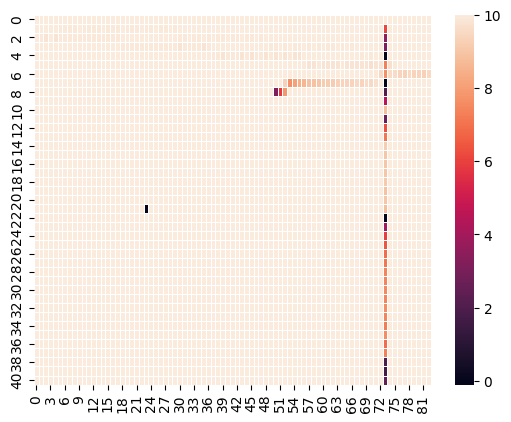

In [81]:
grid = [int(TABLE_WIDTH), int(TABLE_LENGTH)]
grid = np.full(grid, 10.0)
for pos in positions_array:
    pos_final_x = int(TABLE_WIDTH) - pos[0]
    pos_final_y = int(TABLE_LENGTH) - pos[1]
    if grid[pos_final_x, pos_final_y] > 0:
        grid[pos_final_x, pos_final_y] -= 0.1

ax = sns.heatmap(grid, linewidth=0.4)
plt.show()

In [96]:
def total_shots(game_data, shots_correct = False):
    sum_shots = 0
    scored = 0
    for game in game_data:
        for player in game.keys():
            for turn in game[player].keys():
                for status in game[player][turn].keys():
                    if status == 'ended':
                        sum_shots += 1
                        if game[player][turn][status]['scored'] == True:
                            scored += 1
    if shots_correct:
        return sum_shots, scored
    return sum_shots


In [97]:
total_shots(game_data, shots_correct = True)

(3, 0)